In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly_express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [137]:
Foods3_CA_df = pd.read_csv('C:/Users/Jesse/Desktop/ADSP31006/FinalProject/Data/Foods3_CA_df.csv')

In [138]:
Foods3_CA_df.head()

,date,store_id,unit_sold,sell_price,revenue,snap_CA,event1_Christmas,event1_Thanksgiving,event1_NewYear,event1_SuperBowl,event1_LaborDay
0,2011-01-29,CA_1,2268,1.161917,4323.7104,0.0,0,0,0,0,0
1,2011-01-29,CA_2,1575,1.027044,3093.0280,0.0,0,0,0,0,0
2,2011-01-29,CA_3,2478,1.136871,4282.4180,0.0,0,0,0,0,0
3,2011-01-29,CA_4,759,1.047593,1566.5078,0.0,0,0,0,0,0
4,2011-01-30,CA_4,798,1.047593,1600.1709,0.0,0,0,0,0,0


In [139]:
Foods3_CA_df = Foods3_CA_df.sort_values(by=["store_id", "date"])

Foods3_CA_df["unit_sold_lag_30"] = Foods3_CA_df.groupby("store_id")["unit_sold"].shift(30)

Foods3_CA_df.head()

,date,store_id,unit_sold,sell_price,revenue,snap_CA,event1_Christmas,event1_Thanksgiving,event1_NewYear,event1_SuperBowl,event1_LaborDay,unit_sold_lag_30
0,2011-01-29,CA_1,2268,1.161917,4323.7104,0.0,0,0,0,0,0,NaN
7,2011-01-30,CA_1,2198,1.161917,3938.2654,0.0,0,0,0,0,0,NaN
10,2011-01-31,CA_1,1398,1.161917,2756.3080,0.0,0,0,0,0,0,NaN
14,2011-02-01,CA_1,1607,1.161917,3111.3948,1.0,0,0,0,0,0,NaN
16,2011-02-02,CA_1,1496,1.161917,2845.1648,1.0,0,0,0,0,0,NaN


In [140]:
Foods3_CA_df["date"] = pd.to_datetime(Foods3_CA_df["date"], format="%Y-%m-%d")

Foods3_CA_df = Foods3_CA_df[
    (Foods3_CA_df["date"] >= pd.Timestamp("2012-01-01")) & 
    (Foods3_CA_df["date"] <= pd.Timestamp("2015-12-31"))
]

In [141]:
Foods3_CA_df.head()

,date,store_id,unit_sold,sell_price,revenue,snap_CA,event1_Christmas,event1_Thanksgiving,event1_NewYear,event1_SuperBowl,event1_LaborDay,unit_sold_lag_30
1348,2012-01-01,CA_1,1448,1.645839,3213.3958,1.0,0,0,1,0,0,1804.0
1352,2012-01-02,CA_1,2001,1.645839,4684.9550,1.0,0,0,0,0,0,2441.0
1359,2012-01-03,CA_1,1711,1.645839,3916.0360,1.0,0,0,0,0,0,2432.0
1363,2012-01-04,CA_1,1598,1.645839,3606.1812,1.0,0,0,0,0,0,1737.0
1364,2012-01-05,CA_1,1949,1.645839,4310.1980,1.0,0,0,0,0,0,1517.0


In [142]:
print(Foods3_CA_df["date"].min(), Foods3_CA_df["date"].max())

2012-01-01 00:00:00 2015-12-31 00:00:00


In [143]:
Foods3_CA_df["date"] = pd.to_datetime(Foods3_CA_df["date"])

# Check data completeness
full_date_range = pd.date_range(start="2012-01-01", end="2015-12-31")

existing_dates = Foods3_CA_df["date"].unique()

missing_dates = set(full_date_range) - set(existing_dates)

missing_dates_df = pd.DataFrame(sorted(missing_dates), columns=["Missing Dates"])

print("Number of missing days:", len(missing_dates_df))
print(missing_dates_df)

Number of missing days: 0
Empty DataFrame
Columns: [Missing Dates]
Index: []


In [144]:
total_rows = len(Foods3_CA_df)

test_size = int(total_rows * 0.2)

date_range = (Foods3_CA_df["date"].max() - Foods3_CA_df["date"].min()).days
test_days = int(date_range * 0.2)  

last_date = Foods3_CA_df["date"].max()
test_start_date = last_date - pd.Timedelta(days=test_days)

train_df = Foods3_CA_df[Foods3_CA_df["date"] < test_start_date]
test_df = Foods3_CA_df[Foods3_CA_df["date"] >= test_start_date]

print("Training Set Size:", len(train_df))
print("Testing Set Size:", len(test_df))

Training Set Size: 4672
Testing Set Size: 1172


In [145]:
train_df.head()

,date,store_id,unit_sold,sell_price,revenue,snap_CA,event1_Christmas,event1_Thanksgiving,event1_NewYear,event1_SuperBowl,event1_LaborDay,unit_sold_lag_30
1348,2012-01-01,CA_1,1448,1.645839,3213.3958,1.0,0,0,1,0,0,1804.0
1352,2012-01-02,CA_1,2001,1.645839,4684.9550,1.0,0,0,0,0,0,2441.0
1359,2012-01-03,CA_1,1711,1.645839,3916.0360,1.0,0,0,0,0,0,2432.0
1363,2012-01-04,CA_1,1598,1.645839,3606.1812,1.0,0,0,0,0,0,1737.0
1364,2012-01-05,CA_1,1949,1.645839,4310.1980,1.0,0,0,0,0,0,1517.0


In [146]:
test_df.tail()

,date,store_id,unit_sold,sell_price,revenue,snap_CA,event1_Christmas,event1_Thanksgiving,event1_NewYear,event1_SuperBowl,event1_LaborDay,unit_sold_lag_30
7175,2015-12-27,CA_4,721,2.924935,1891.2354,0.0,0,0,0,0,0,563.0
7179,2015-12-28,CA_4,753,2.924935,2110.1110,0.0,0,0,0,0,0,748.0
7183,2015-12-29,CA_4,642,2.924935,1747.9710,0.0,0,0,0,0,0,934.0
7184,2015-12-30,CA_4,713,2.924935,1981.7717,0.0,0,0,0,0,0,885.0
7188,2015-12-31,CA_4,1072,2.924935,2814.8704,0.0,0,0,0,0,0,805.0


In [147]:
Foods3_CA_df.info

<bound method DataFrame.info of            date store_id  unit_sold  sell_price    revenue  snap_CA  \
1348 2012-01-01     CA_1       1448    1.645839  3213.3958      1.0   
1352 2012-01-02     CA_1       2001    1.645839  4684.9550      1.0   
1359 2012-01-03     CA_1       1711    1.645839  3916.0360      1.0   
1363 2012-01-04     CA_1       1598    1.645839  3606.1812      1.0   
1364 2012-01-05     CA_1       1949    1.645839  4310.1980      1.0   
...         ...      ...        ...         ...        ...      ...   
7175 2015-12-27     CA_4        721    2.924935  1891.2354      0.0   
7179 2015-12-28     CA_4        753    2.924935  2110.1110      0.0   
7183 2015-12-29     CA_4        642    2.924935  1747.9710      0.0   
7184 2015-12-30     CA_4        713    2.924935  1981.7717      0.0   
7188 2015-12-31     CA_4       1072    2.924935  2814.8704      0.0   

      event1_Christmas  event1_Thanksgiving  event1_NewYear  event1_SuperBowl  \
1348                 0            

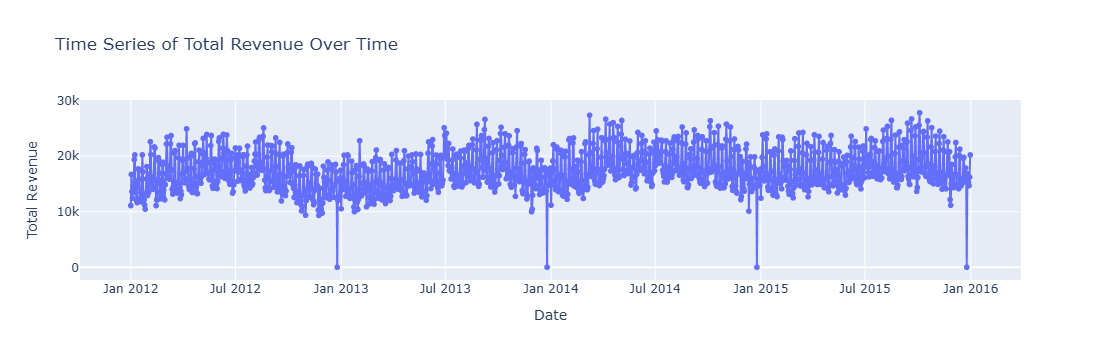

In [148]:
# Aggregate total revenue by date
total_revenue_by_date = Foods3_CA_df.groupby("date", as_index=False)["revenue"].sum()

fig = px.line(
    total_revenue_by_date,
    x="date",
    y="revenue",
    title="Time Series of Total Revenue Over Time",
    labels={"revenue": "Total Revenue", "date": "Date"},
    markers=True  
)

fig.show()

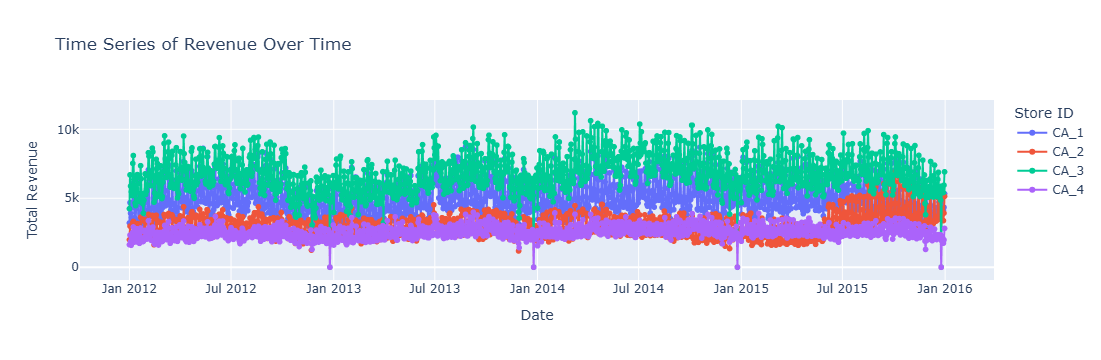

In [149]:
fig = px.line(
    Foods3_CA_df,
    x="date",
    y="revenue",
    color="store_id", 
    title="Time Series of Revenue Over Time",
    labels={"revenue": "Total Revenue", "date": "Date", "store_id": "Store ID"},
    markers=True 
)

fig.show()

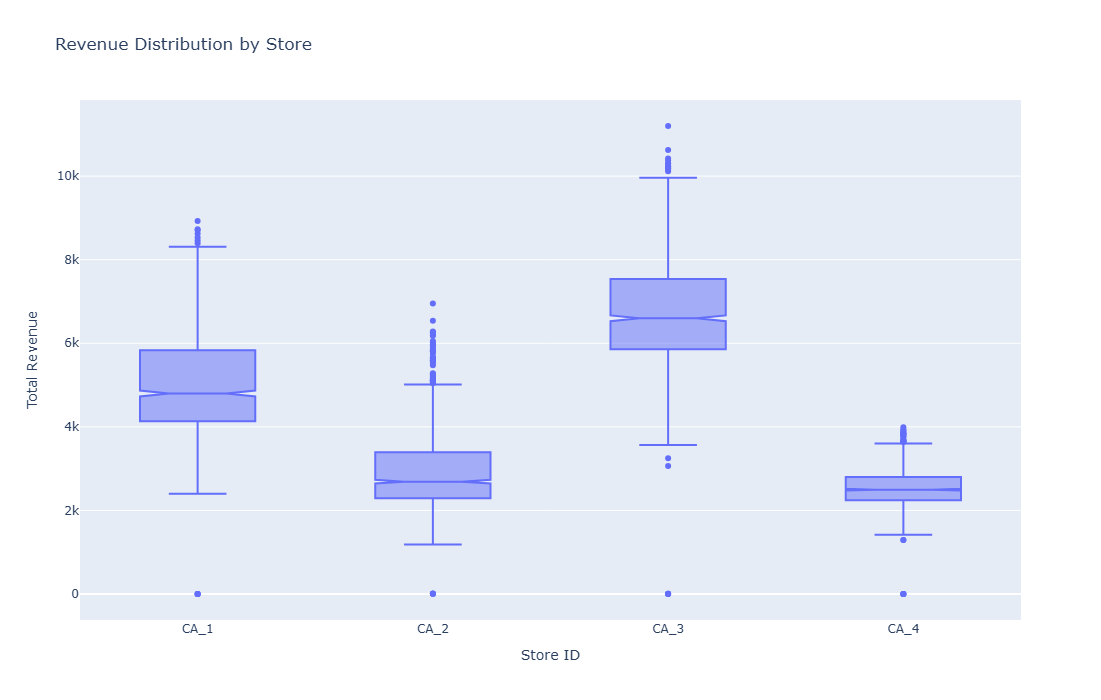

In [150]:
import plotly.express as px

fig = px.box(
    Foods3_CA_df,
    x="store_id",
    y="revenue",
    title="Revenue Distribution by Store",
    labels={"revenue": "Total Revenue", "store_id": "Store ID"},
    notched=True
)

# Adjust figure size and layout
fig.update_layout(
    width=400,  
    height=700,  
    boxmode='group'  
)

fig.show()


In [151]:
sample = Foods3_CA_df.copy()

In [152]:
sample=pd.get_dummies(sample, columns=['store_id'], prefix='store', dtype=int)

In [153]:
sample.head()

,date,unit_sold,sell_price,revenue,snap_CA,event1_Christmas,event1_Thanksgiving,event1_NewYear,event1_SuperBowl,event1_LaborDay,unit_sold_lag_30,store_CA_1,store_CA_2,store_CA_3,store_CA_4
1348,2012-01-01,1448,1.645839,3213.3958,1.0,0,0,1,0,0,1804.0,1,0,0,0
1352,2012-01-02,2001,1.645839,4684.9550,1.0,0,0,0,0,0,2441.0,1,0,0,0
1359,2012-01-03,1711,1.645839,3916.0360,1.0,0,0,0,0,0,2432.0,1,0,0,0
1363,2012-01-04,1598,1.645839,3606.1812,1.0,0,0,0,0,0,1737.0,1,0,0,0
1364,2012-01-05,1949,1.645839,4310.1980,1.0,0,0,0,0,0,1517.0,1,0,0,0
